# UAV Digital Twin for Communication Optimization

## About
This simulation combines:
* OpenStreetMaps Data
* Sionna Ray Tracing
* Simulation of Urban MObility (SUMO)
* Custom UAV Control Framework

To produce a digital twin that can be used for training a reinforcement learning model to optimize the locations of UAVs for their communication with the ground users.

## Functionality
This digital twin provides functionality for:
* Loading scene data from an OpenStreetMaps export
* Loading pedestrian data from a SUMO export
* Adding and controlling UAV devices
* Calculating UAV energy consumption based on movements
* Moving pedestrian positions
* Computing the signal quality for a given simulation state
* Visualizing scenes, UAVs, ground users, paths, and coverage maps

## What's Next
The biggest thing that the simulation is missing is more concreteness with the computation of the path quality. It would be better to measure another quantity, like throughput, which is more grounded in the real world than some arbitrary comparitive measure of path quality.

# Digital Twin Demonstration
This notebook runs through some of the features of the digital twin, and how to implement features of the digital twin. As you read through, please experiment with the parameters to see if the digital twin meets the needs of your project.

## Creating the Environment
* The environment is the single container for the digital twin simulation. It should be a singleton instance and most all function calls should be made through the environment instance.
* The environment creation takes arguments to the data from Mitsuba Blender and SUMO to construct the scene and ground users, respectively.
* It also takes some parameters about the time granularity, assumed pedestrian height, receivers, and the wind.

In [2]:
# TODO: Add information about how the files are generated into this program.
# Importing the Framework and other important libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from EnvironmentFramework import Environment, UAV, GroundUser
from sionna.rt import Antenna, AntennaArray

In [ ]:
# Creating the environment, this could take a couple minutes
env = Environment("C:/Users/legoe/Blender/BlenderDataFiles/RaleighUnionSquareMitsubaExport/raleigh_union_square_mitsuba.xml",
                  "C:/Users/legoe/Sumo/2024-10-04-09-05-18/simulated_final_person_new.csv",
                  time_step=1, ped_height=1.5, ped_rx=True, wind_vector=np.zeros(3))

## Visualizing the Environment
* The scene.preview function is the primary way to see the scene.
* It can be used to see UAVs, Ground Users, traced paths, and coverage maps

In [2]:
env.scene.preview(show_devices=True)

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

## Visualizing Ground Users
* Because the ground users can sometimes be difficult to see among the buildings, you can visualize their distribution seperately with the plotGUs function.
* This function returns a 2D plot of the Ground Users in x and y.
* This could be used to look for clusters or patterns in the Ground Users, for some UAV positioning algorithms

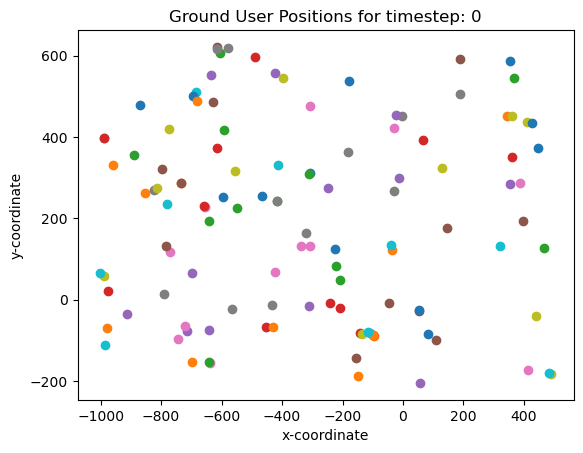

In [3]:
env.plotGUs()

## Instantiating Test UAVs
* The UAV supports an unlimited number of UAVs, but it is easier to visualize the changes in path quality and consumption for just a few devices.
* Building the UAVs requires an initial unique id, mass, efficiency, position, velocity, bandwidth, and rotor area
* The efficiency measure the amount of energy goes towards movement, instead of being lost to heat
* The rotor area is used for the calculation of the hovering energy cost. A higher rotor area means that the UAV uses less energy to hover.

In [4]:
# Defining colors for consistancy
c = np.random.rand(5, 3)

env.addUAV('a', mass=10, efficiency=0.8, pos=np.array([0, 0, 30]), vel=np.zeros(3), color=c[0], bandwidth=50, rotor_area=0.5)
env.addUAV('b', mass=10, efficiency=0.8, pos=np.array([0, -500, 30]), vel=np.zeros(3), color=c[1], bandwidth=50, rotor_area=0.5)
env.addUAV('c', mass=10, efficiency=0.8, pos=np.array([500, 0, 30]), vel=np.zeros(3), color=c[2], bandwidth=50, rotor_area=0.5)
env.addUAV('d', mass=10, efficiency=0.8, pos=np.array([0, 500, 30]), vel=np.zeros(3), color=c[3], bandwidth=50, rotor_area=0.5)
env.addUAV('e', mass=10, efficiency=0.8, pos=np.array([-500, 0, 30]), vel=np.zeros(3), color=c[4], bandwidth=50, rotor_area=0.5)

In [5]:
env.scene.preview(show_devices=True)

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

## Running the simulation through some time steps
* We will use random position changes to move the UAVs in a random independent motion
* We will keep track of the general path quality and the consumption of the UAVs to see how they change over time
* This can easily be expanded to a greater number of time steps

In [6]:
# Change path quality to different name
# Change path quality to 
num_steps = 10
scale = 2
path_quality = []
consumption = []

# Setting the transmitter and receiver arrays
env.setTransmitterArray(AntennaArray(antenna=Antenna("tr38901", "V"), positions=tf.Variable([0.0,0.0,0.0])))
env.setReceiverArray(AntennaArray(antenna=Antenna("tr38901", "V"), positions=tf.Variable([0.0,0.0,0.0])))

for i in range(num_steps):
    scale = i
    env.step({'a': [env.uavs['a'].pos + scale * np.random.rand(3), np.zeros(3)],
              'b': [env.uavs['b'].pos + scale * np.random.rand(3), np.zeros(3)], 
              'c': [env.uavs['c'].pos + scale * np.random.rand(3), np.zeros(3)], 
              'd': [env.uavs['d'].pos + scale * np.random.rand(3), np.zeros(3)], 
              'e': [env.uavs['e'].pos + scale * np.random.rand(3), np.zeros(3)]})
    consumption.append(list(env.getConsumptions().values()))
    path_quality.append(env.computeGeneralLoss(2, 100000))
    env.scene.preview(show_devices=True)

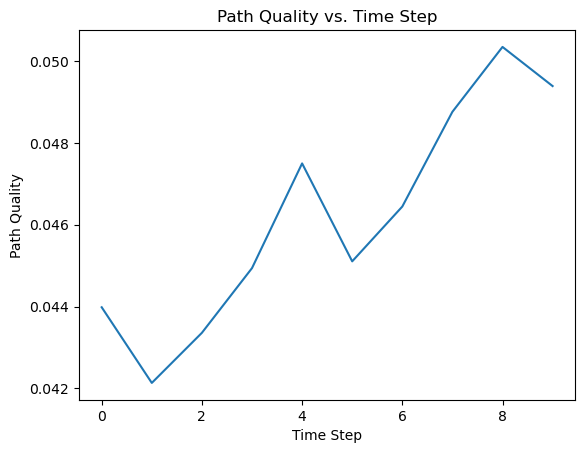

In [7]:
import matplotlib.pyplot as plt
plt.plot(np.array(path_quality))
plt.title("Path Quality vs. Time Step")
plt.xlabel("Time Step")
plt.ylabel("Path Quality");

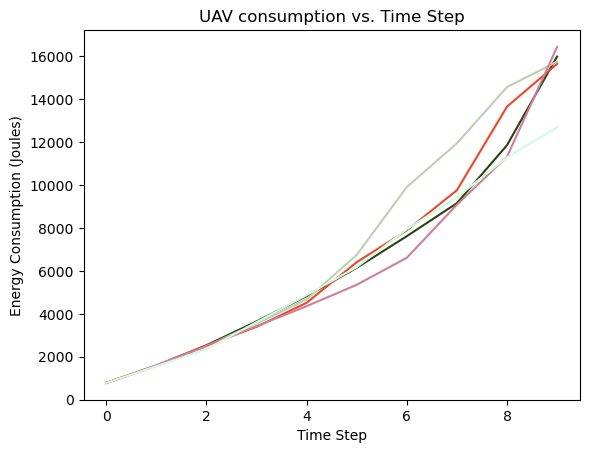

In [8]:
consumption = np.array(consumption)
for i in range(5):
    plt.plot(consumption[:,i], color=c[i])
plt.title("UAV consumption vs. Time Step")
plt.xlabel("Time Step")
plt.ylabel("Energy Consumption (Joules)");

## Test Experiment: Baseline Random vs. K-Means Clustering
* We will attempt to position the UAVs optimally with two different methods, and then measure their respective path qualities.
* The random method distributes the UAVs completely randomly through the simulation
* The K-Means clusters based on the positions of the Ground Users, and then locates the UAVs at the cluster centers

We expect the K-Means Clustering Positioning to give better results than the randomness, but does it actually? And if so, by how much does it improve the score?

In [9]:
# New Imports
from sklearn.cluster import KMeans

In [10]:
# Testing the random distribution method

qualities = []
for i in range(num_steps):
    for uav in ['a', 'b', 'c', 'd', 'e']:
        position = np.array([np.random.randint(-500, 500), np.random.randint(-500, 500), 30])
        env.moveAbsUAV(uav, position, np.zeros(3))
    qualities.append(env.computeGeneralLoss(2, 100000))
    env.scene.preview(show_devices=True)

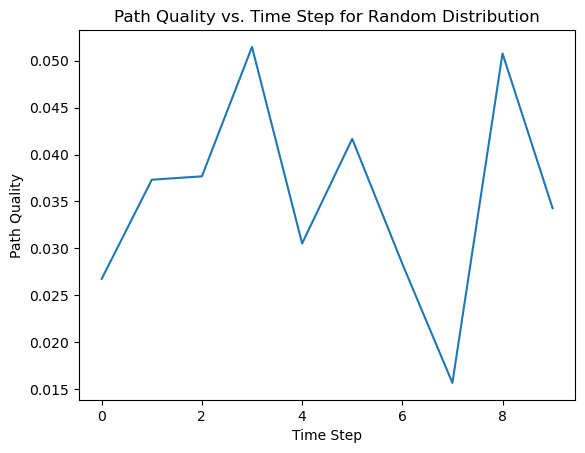

In [11]:
plt.plot(np.array(qualities))
plt.title("Path Quality vs. Time Step for Random Distribution")
plt.xlabel("Time Step")
plt.ylabel("Path Quality");

In [12]:
# Testing the K-Means model

qualities = []
for i in range(num_steps):
    model = KMeans(n_clusters=5)
    X = []
    for gu in env.gus:
        X.append(gu.pos)
    model.fit(np.array(X));

    tags = ['a', 'b', 'c', 'd', 'e']
    for i in range(len(tags)):
        position = np.array([model.cluster_centers_[i][0], model.cluster_centers_[i][1], 30])
        env.moveAbsUAV(tags[i], position, np.zeros(3))

    qualities.append(env.computeGeneralLoss(2, 100000))
    env.scene.preview(show_devices=True)

C:\Users\legoe\miniconda3\envs\RL-DT-ENV\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\legoe\miniconda3\envs\RL-DT-ENV\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\legoe\miniconda3\envs\RL-DT-ENV\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\legoe\miniconda3\envs\RL-DT-ENV\Lib\site-packages\sklearn\cluster\_kmeans.py:14

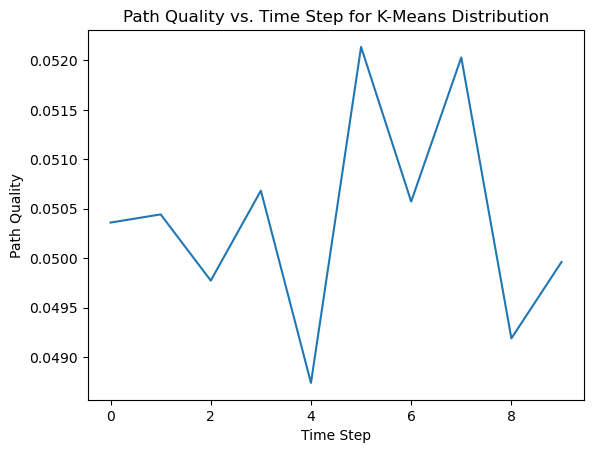

In [13]:
plt.plot(np.array(qualities))
plt.title("Path Quality vs. Time Step for K-Means Distribution")
plt.xlabel("Time Step")
plt.ylabel("Path Quality");

# Demonstration Experiment
The purpose of this new experiment is to get a visual demonstration for the coverage map functionality, path visualization, consumption, and actor positions all within a single video. The user will then be able to see how the simulation actively updates each of these features as the simulation steps through multiple time steps.

In [1]:
# Necessary Imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from EnvironmentFramework import Environment, UAV, GroundUser
from sionna.rt import Antenna, AntennaArray

## Generating Random Positions
We create a series of random positions for the UAVs so that we can keep the experiment consistant across future steps. Additionally, the results from the signal quality score and the consumption will be consistent with each other.

In [30]:
np.random.seed(1)
simulation_steps = 250
scale = 3
num_uavs = 4
signs = [[1, 1], [-1, 1], [1, -1], [-1, -1]]  # Signs to move UAVs in different directions
positions = []

row = {}
for i in range(num_uavs):
    row[str(i)] = [np.zeros(3), np.random.rand(3)]
positions.append(row)

for i in range(simulation_steps):
    row = {}
    
    for j in range(num_uavs):
        pos = scale * np.random.rand(3)
        pos[0] = pos[0] * signs[j][0] + positions[i][str(j)][0][0]
        pos[1] = pos[1] * signs[j][1] + positions[i][str(j)][0][1]
        pos[2] = 30
        row[str(j)] = [pos, np.random.rand(3)]
    positions.append(row)

## Creating a New Environment
We create a new environment to reset the system variables to move towards a new demonstration of the evolution of coverage maps, UAV positions, pedestrian positions, UAV energy consumption, and the overall path quality score.

In [ ]:
# Resetting the environment variable
env = Environment("C:/Users/legoe/Blender/BlenderDataFiles/RaleighUnionSquareMitsubaExport/raleigh_union_square_mitsuba.xml",
                  "C:/Users/legoe/Sumo/2024-10-04-09-05-18/simulated_final_person_new.csv",
                  time_step=1, ped_height=1.5, ped_rx=True, wind_vector=np.zeros(3))

Loading Scene


## Instantiating UAVs
Creating 5 new UAVs in random positions in around the map.

In [ ]:
c = np.random.rand(4, 3)

env.addUAV('0', mass=10, efficiency=0.8, pos=np.array([0, 0, 30]), vel=np.zeros(3), color=c[0], bandwidth=50, rotor_area=0.5)
env.addUAV('1', mass=10, efficiency=0.8, pos=np.array([0, 0, 30]), vel=np.zeros(3), color=c[1], bandwidth=50, rotor_area=0.5)
env.addUAV('2', mass=10, efficiency=0.8, pos=np.array([0, 0, 30]), vel=np.zeros(3), color=c[2], bandwidth=50, rotor_area=0.5)
env.addUAV('3', mass=10, efficiency=0.8, pos=np.array([0, 0, 30]), vel=np.zeros(3), color=c[3], bandwidth=50, rotor_area=0.5)

## Instantiating the Antenna Arrays
Adding default antenna arrays to the simulation

In [ ]:
env.setTransmitterArray(AntennaArray(antenna=Antenna("tr38901", "V"), positions=tf.Variable([0.0,0.0,0.0])))
env.setReceiverArray(AntennaArray(antenna=Antenna("tr38901", "V"), positions=tf.Variable([0.0,0.0,0.0])))

In [ ]:
env.scene.preview(show_devices=True)

## Visualizing UAV Movement Patterns
Using the scene preview to show how the UAVs are moving through the time steps. This helps confirm the randomized path that was generated in the previous cells.

In [29]:
for i in range(simulation_steps):
    env.step(positions[i + 1])

    print(env.getUAVConsumption('0'))

    env.scene.preview(show_devices=True)

TypeError: can only concatenate str (not "int") to str

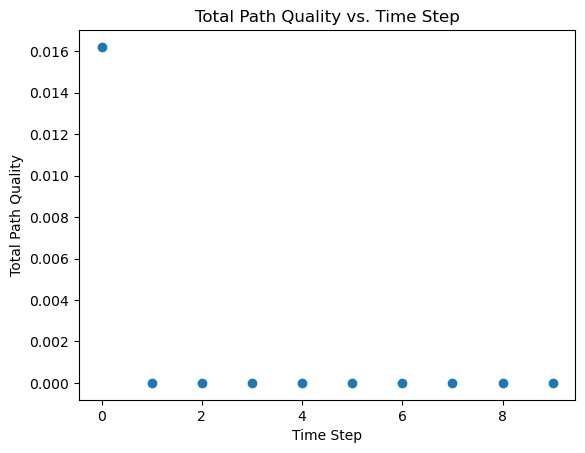

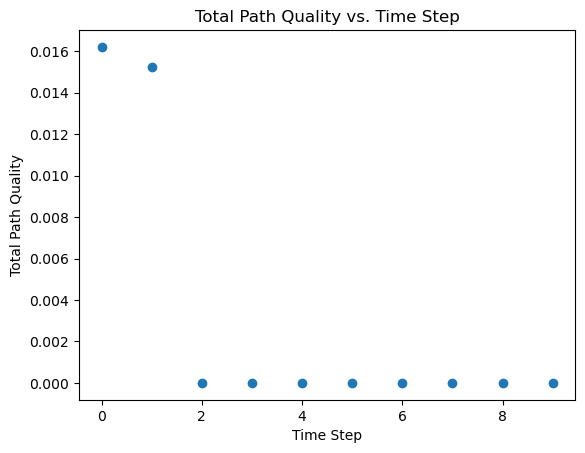

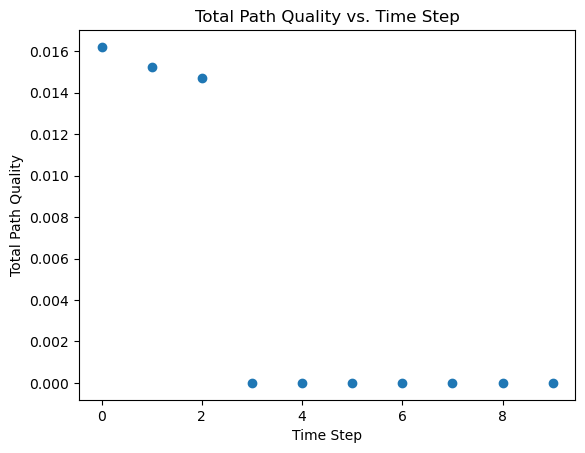

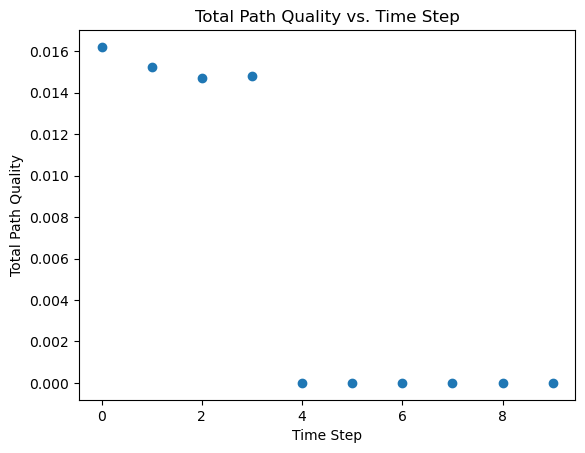

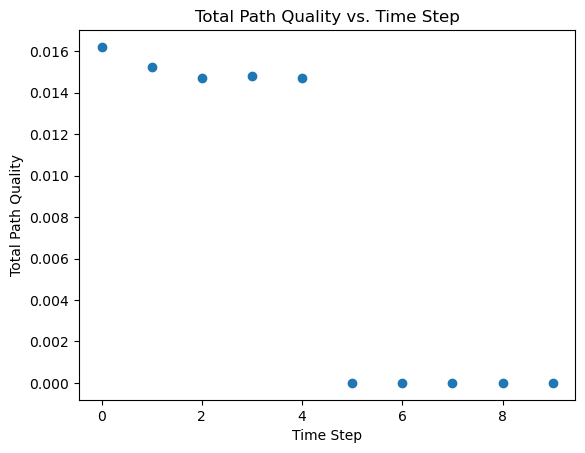

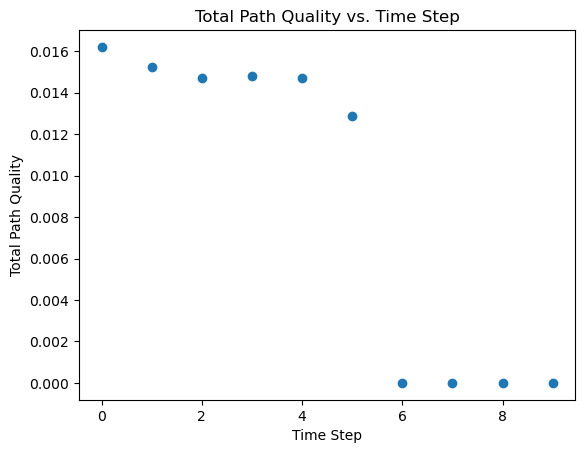

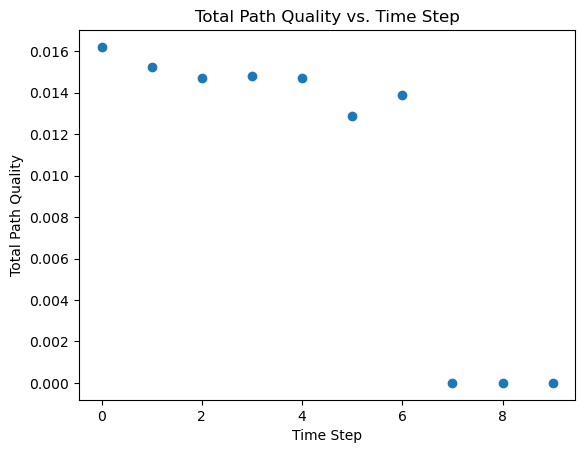

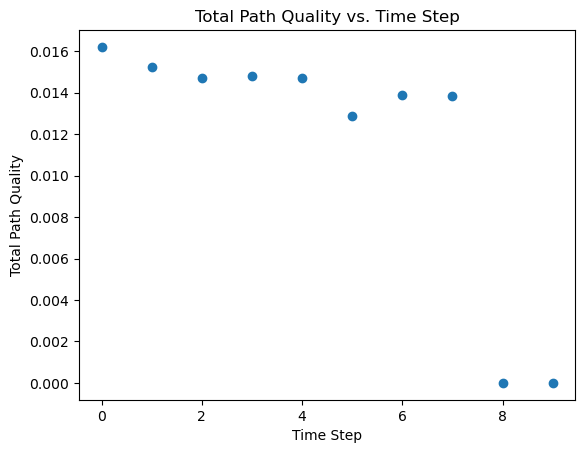

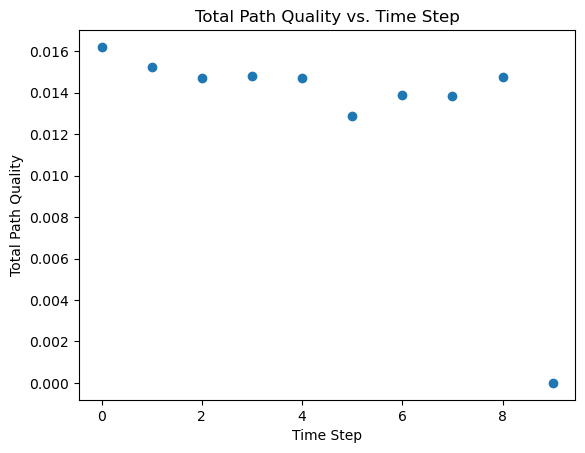

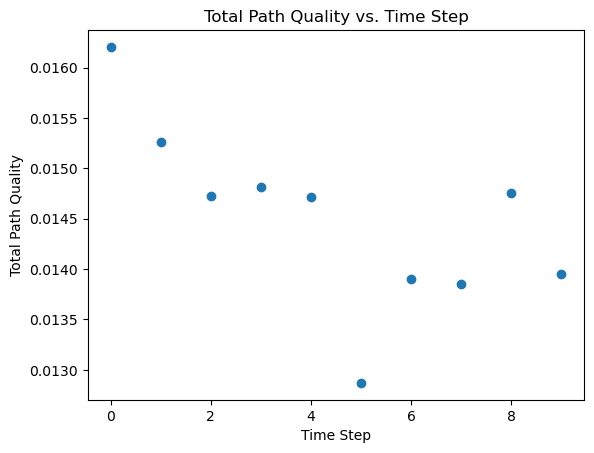

In [162]:
import time

path_qualities = np.zeros(simulation_steps)

for i in range(simulation_steps):
    env.step(positions[i])

    path_qualities[i] = env.computeGeneralLoss(max_depth=2, num_samples=10000)

    plt.scatter(x=np.arange(simulation_steps), y=path_qualities)
    plt.title("Total Path Quality vs. Time Step")
    plt.xlabel("Time Step")
    plt.ylabel("Total Path Quality")
    plt.show()

In [155]:
for i in range(simulation_steps):
    print(i)
    env.step(positions[i])

    coverage_map = env.computeCoverageMap(max_depth=2, num_samples=1000000)

    env.scene.preview(show_devices=True, coverage_map=coverage_map)

0
1
2
3
4
5
6
7
8
9


In [ ]:
plt.ion()
fig = plt.figure() 
ax = fig.add_subplot(111)

lines = []
for i in range(5):
    lines.append(ax.scatter(
lines = []
for i in range(5):
    lines.append(ax.scatter(np.arange(simulation_steps), consumptions[i]))

In [ ]:
print(consumptions)